# Scaling Python with Azure ML and Dask

![Describe gif](media/describe3.gif)

## Environment setup

In [ ]:
pip install --upgrade azureml-sdk[notebooks] azureml-dataprep[fuse] fastparquet pyarrow dask distributed lz4

In [ ]:
pip uninstall azureml-samples -y

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML('<script>Jupyter.notebook.kernel.restart()</script>')

## Imports

In [1]:
import dask, os, sys, glob, socket
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

from azureml.core import Workspace, Experiment, Dataset, Environment
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.widgets import RunDetails
from azureml.core.runconfig import MpiConfiguration
from azureml.train.estimator import Estimator
from azureml.core.compute import ComputeTarget, AmlCompute
from IPython.core.display import HTML

import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline 

## Azure ML Setup

In [2]:
ws = Workspace.from_config()
ws

Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')

In [3]:
env_name = 'dask7'

if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

('dask7', '1')

In [4]:
dataset_name = 'weather-files'
data_paths   = ['https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet']

if dataset_name not in ws.datasets:
    ds = Dataset.File.from_files(data_paths, validate=False)
    ds = ds.register(ws, dataset_name)
else:
    ds = ws.datasets[dataset_name]
    
ds

{
  "source": [
    "https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet"
  ],
  "definition": [
    "GetFiles"
  ],
  "registration": {
    "id": "132f84ee-4f89-45f7-b2ca-fe22fe332295",
    "name": "weather-files",
    "version": 1,
    "workspace": "Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

In [5]:
pool_name = 'dask-cluster'

if pool_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                 = 'STANDARD_DS13_V2',
             max_nodes               = 100,
             vnet_resourcegroup_name = ws.resource_group,
             vnet_name               = 'dask-vnet',
             subnet_name             = 'default'
    )
    
    ct = ComputeTarget.create(ws, pool_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[pool_name]
    
ct

AmlCompute(workspace=Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg'), name=dask-cluster, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copetersrg/providers/Microsoft.MachineLearningServices/workspaces/bigdata/computes/dask-cluster, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Local Dask Client setup

In [19]:
dashboard_port = 9777

c = Client(dashboard_address=f':{dashboard_port}')
c.restart()

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker




<Client: 'tcp://127.0.0.1:37237' processes=5 threads=20, memory=147.86 GB>


## Download dataset and explore it 

In [20]:
data_path = '/mnt/noaa'
os.system('sudo chmod 777 /mnt') # stupid 

0

In [21]:
ds.download(data_path)

array(['/mnt/noaa/year=2008/month=1/part-00005-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-6.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=10/part-00001-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-2.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=11/part-00006-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-7.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=12/part-00000-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-1.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=2/part-00011-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-12.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=3/part-00003-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-4.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=4/part-00008-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-9.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=5/part-00002-tid-7339844144521752319-f

In [22]:
files = dask.delayed(glob.glob)(f'{data_path}/year=*/month=*/*.parquet', recursive=True).compute()
len(files)

144

In [23]:
files = dask.delayed(glob.glob)(f'{data_path}/year=2019/month=*/*.parquet', recursive=True).compute()
len(files)

12

In [24]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])
df.head()

usaf   wban            datetime  latitude  longitude  elevation  \
0  999999  25711 2019-02-01 00:00:00    57.158   -170.212        6.0   
1  999999  25711 2019-02-01 00:05:00    57.158   -170.212        6.0   
2  999999  25711 2019-02-01 00:10:00    57.158   -170.212        6.0   
3  999999  25711 2019-02-01 00:15:00    57.158   -170.212        6.0   
4  999999  25711 2019-02-01 00:20:00    57.158   -170.212        6.0   

   windAngle  windSpeed  temperature  seaLvlPressure   ...     \
0        NaN        8.9          3.6             NaN   ...      
1        NaN        NaN          3.6             NaN   ...      
2        NaN        NaN          3.6             NaN   ...      
3        NaN        NaN          3.5             NaN   ...      
4        NaN        NaN          3.5             NaN   ...      

  pastWeatherIndicator  precipTime  precipDepth  snowDepth    stationName  \
0                  NaN         1.0          0.0        NaN  ST. PAUL 4 NE   
1                  NaN         NaN          NaN        NaN  ST. PAUL 4 NE   
2                  NaN         NaN          NaN        NaN  ST. PAUL 4 NE   
3                  NaN         NaN          NaN        NaN  ST. PAUL 4 NE   
4                  NaN         NaN          NaN        NaN  ST. PAUL 4 NE   

   countryOrRegion           p_k  year day  version  
0               US  999999-25711  2019   1      1.0  
1               US  999999-25711  2019   1      1.0  
2               US  999999-25711  2019   1      1.0  
3               US  999999-25711  2019   1      1.0  
4               US  999999-25711  2019   1      1.0  

[5 rows x 22 columns]

In [25]:
%time len(df)

CPU times: user 933 ms, sys: 208 ms, total: 1.14 s
Wall time: 9.11 s


124956666

In [26]:
%time df.describe().compute()

CPU times: user 9.24 s, sys: 1.46 s, total: 10.7 s
Wall time: 50.4 s


latitude     longitude     elevation     windAngle     windSpeed  \
count  1.249567e+08  1.249567e+08  1.249567e+08  1.066881e+08  1.105223e+08   
mean   3.605756e+01 -3.450950e+01  3.812591e+02  1.661066e+02  3.398631e+00   
std    2.368553e+01  7.841385e+01  6.997652e+02  1.140600e+02  2.818132e+00   
min   -9.000000e+01 -1.799830e+02 -3.880000e+02  0.000000e+00  0.000000e+00   
25%    3.283500e+01 -9.120000e+01  3.700000e+01  7.000000e+01  1.500000e+00   
50%    4.170600e+01 -4.545400e+01  1.810000e+02  1.900000e+02  3.100000e+00   
75%    4.922000e+01  2.136700e+01  4.350000e+02  2.800000e+02  5.100000e+00   
max    8.365600e+01  1.797500e+02  9.999000e+03  3.600000e+02  9.000000e+01   

        temperature  seaLvlPressure  presentWeatherIndicator  \
count  1.222281e+08    5.175650e+07             1.298102e+07   
mean   1.246802e+01    1.014604e+03             3.558280e+01   
std    1.257927e+01    9.117536e+00             3.022886e+01   
min   -9.130000e+01    8.614000e+02             0.000000e+00   
25%    7.000000e+00    1.011000e+03             1.000000e+01   
50%    1.590000e+01    1.017300e+03             6.000000e+01   
75%    2.700000e+01    1.024600e+03             7.100000e+01   
max    6.150000e+01    1.090000e+03             9.900000e+01   

       pastWeatherIndicator    precipTime   precipDepth     snowDepth  \
count          4.331517e+06  3.038590e+07  3.038590e+07  1.033798e+06   
mean           4.214374e+00  1.607452e+01  2.462784e+03  1.392134e+01   
std            3.022310e+00  3.064271e+01  4.298749e+03  2.493581e+01   
min            0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%            2.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
50%            5.000000e+00  3.000000e+00  4.000000e+00  3.000000e+00   
75%            8.000000e+00  2.400000e+01  9.999000e+03  5.100000e+01   
max            9.000000e+00  9.900000e+01  9.999000e+03  7.000000e+02   

              year           day      version  
count  124956666.0  1.249567e+08  124956666.0  
mean        2019.0  1.550841e+01          1.0  
std            0.0  8.755722e+00          0.0  
min         2019.0  1.000000e+00          1.0  
25%         2019.0  8.000000e+00          1.0  
50%         2019.0  1.600000e+01          1.0  
75%         2019.0  2.400000e+01          1.0  
max         2019.0  3.100000e+01          1.0

In [27]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 1.83 s, sys: 275 ms, total: 2.1 s
Wall time: 24.4 s
Dataframe is: 59.99GB


In [28]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute()
means.head()

CPU times: user 4.94 s, sys: 783 ms, total: 5.73 s
Wall time: 1min 3s


latitude  longitude   elevation   windAngle  windSpeed  \
datetime                                                              
2019-02-01  36.342851 -36.225958  386.512358  139.531009   3.450410   
2019-02-02  36.405091 -37.887632  388.346255  151.841651   3.601617   
2019-02-03  36.571584 -38.803773  389.887939  164.778202   3.654426   
2019-02-04  36.568504 -38.581856  388.737666  166.438896   3.720909   
2019-02-05  36.553614 -38.426739  394.030577  158.347880   3.297028   

            temperature  seaLvlPressure  presentWeatherIndicator  \
datetime                                                           
2019-02-01     2.127135     1013.997545                38.060859   
2019-02-02     3.887103     1014.223535                33.697386   
2019-02-03     4.706988     1014.996356                38.065275   
2019-02-04     4.290343     1017.033232                41.137543   
2019-02-05     3.717550     1017.846254                38.811231   

            pastWeatherIndicator  precipTime  precipDepth  snowDepth    year  \
datetime                                                                       
2019-02-01              3.990010   15.539243  2356.555868  26.642213  2019.0   
2019-02-02              4.042323   15.177613  2305.886235  26.449092  2019.0   
2019-02-03              4.143801   14.623373  2167.646220  24.357468  2019.0   
2019-02-04              4.030368   14.840486  2241.131685  26.898206  2019.0   
2019-02-05              3.801554   15.247313  2290.109623  27.410412  2019.0   

            day  version  
datetime                  
2019-02-01  1.0      1.0  
2019-02-02  2.0      1.0  
2019-02-03  3.0      1.0  
2019-02-04  4.0      1.0  
2019-02-05  5.0      1.0

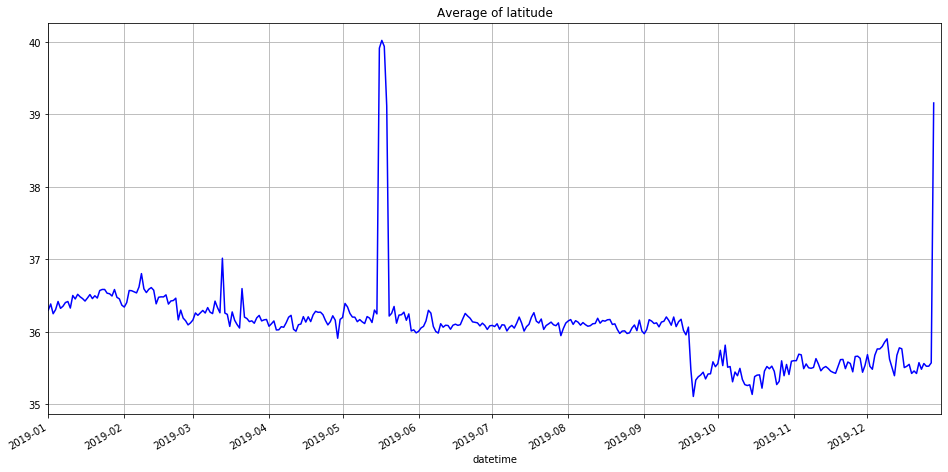

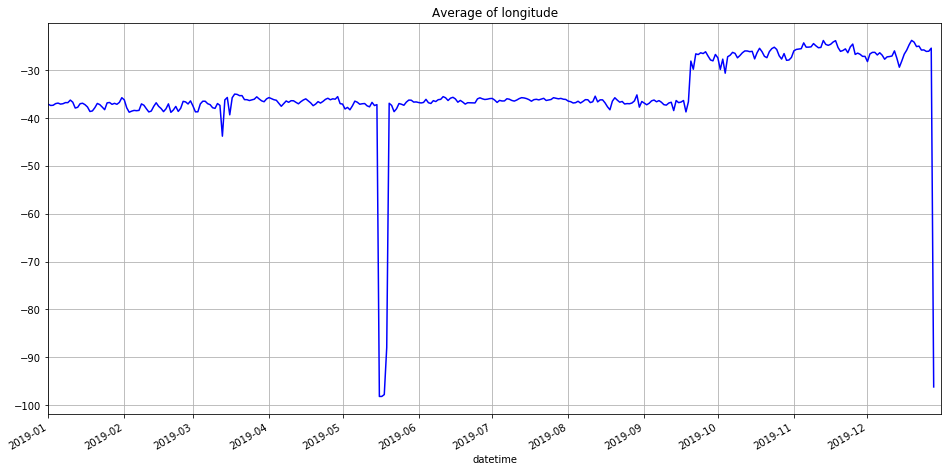

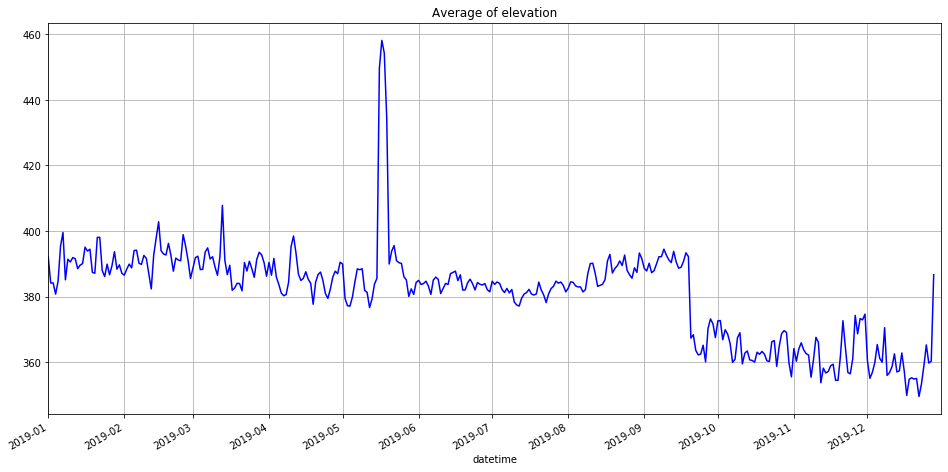

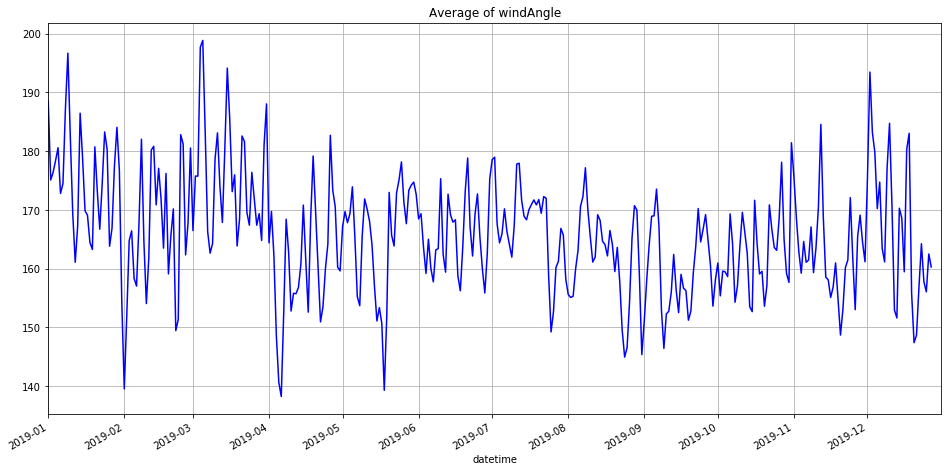

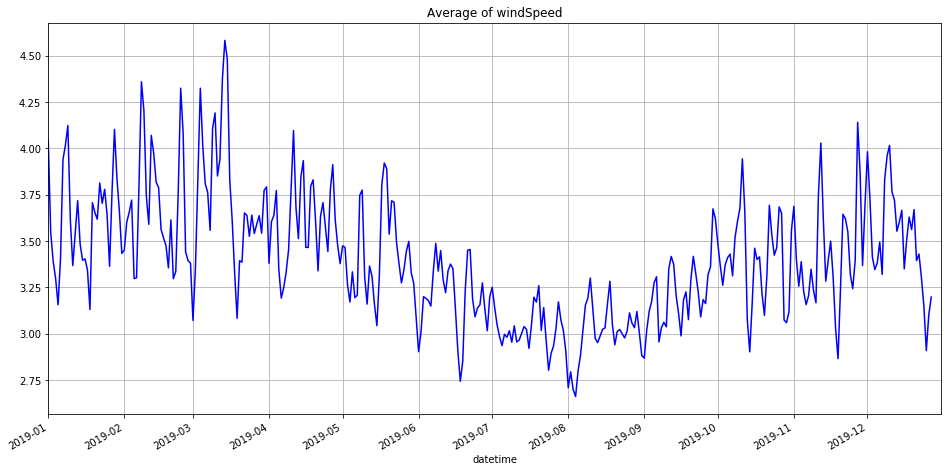

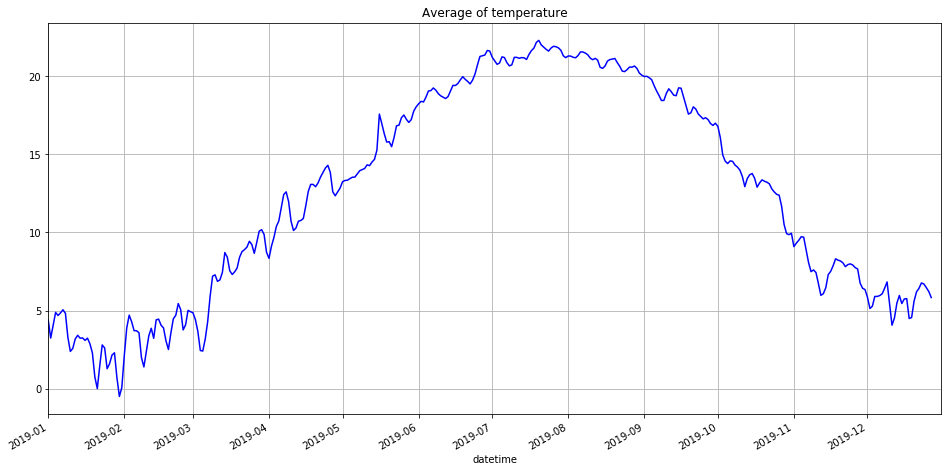

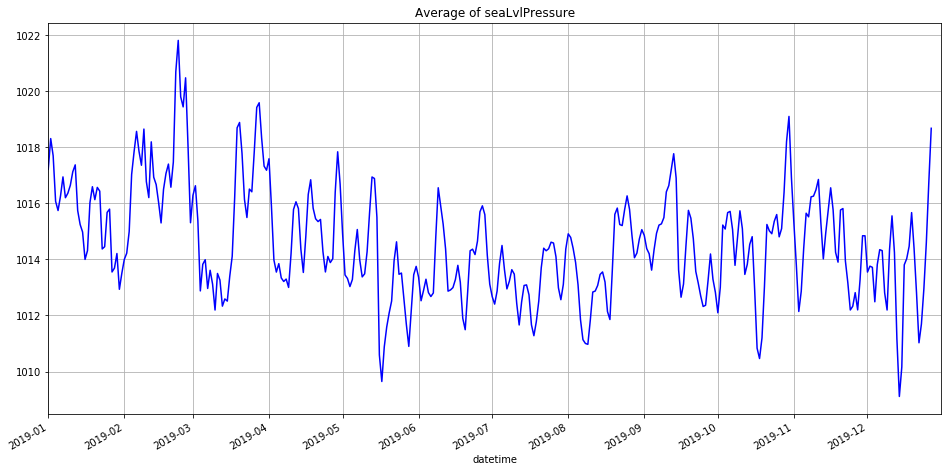

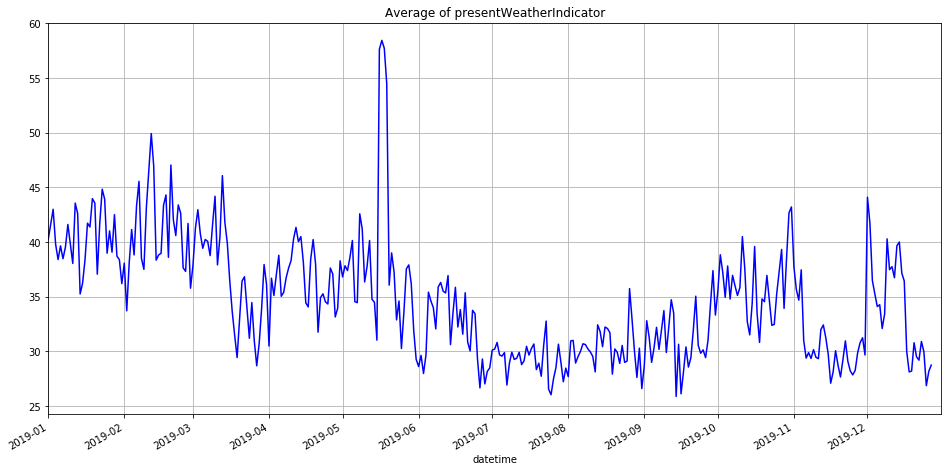

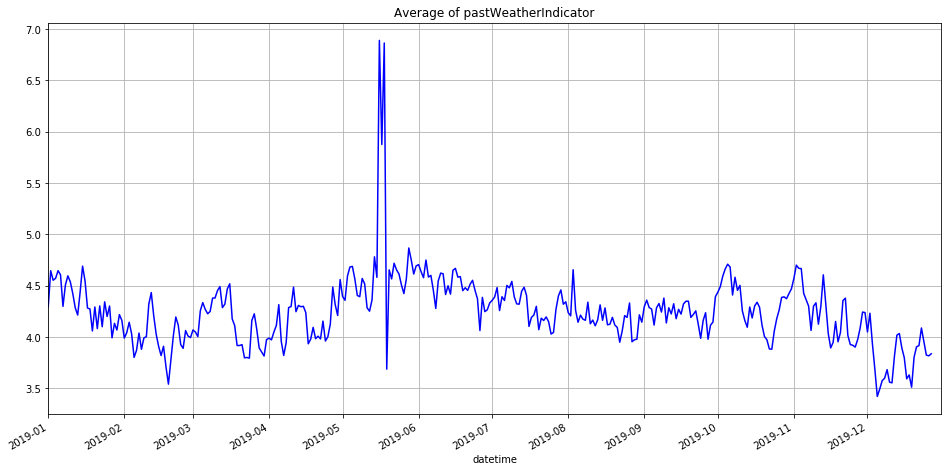

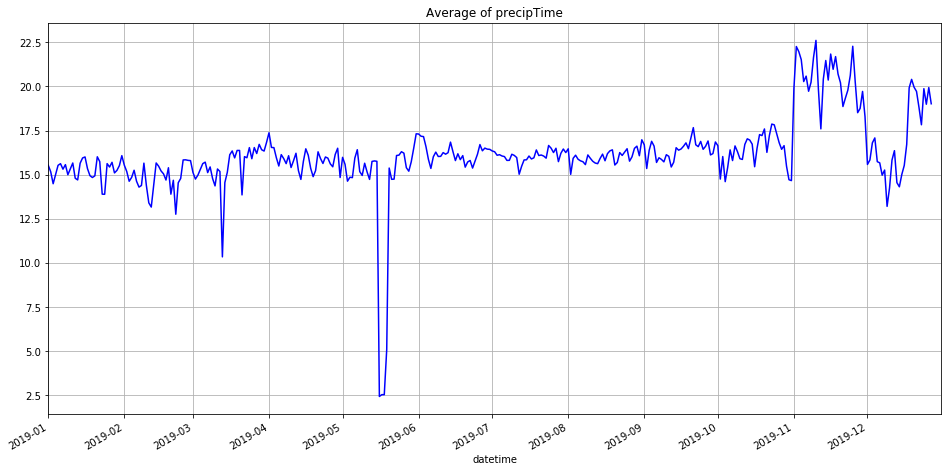

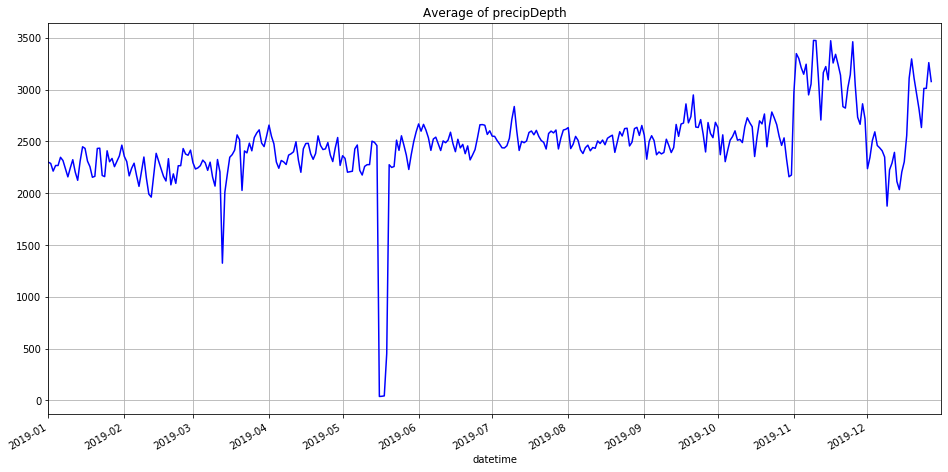

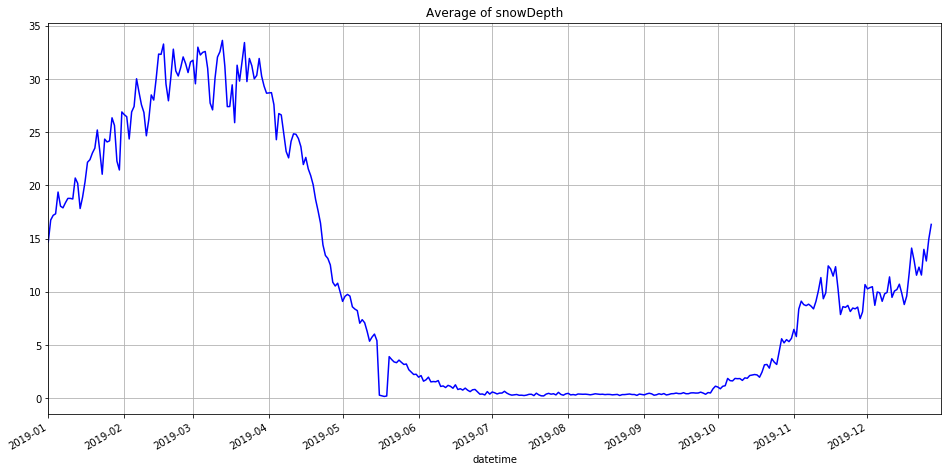

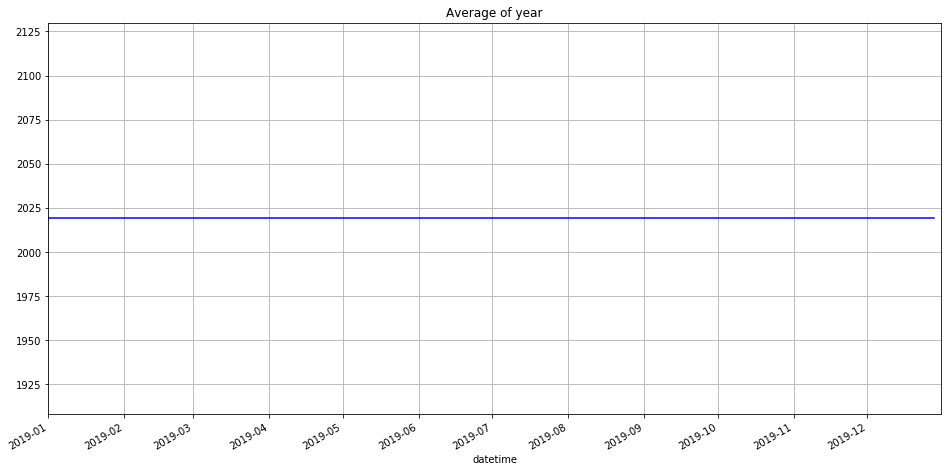

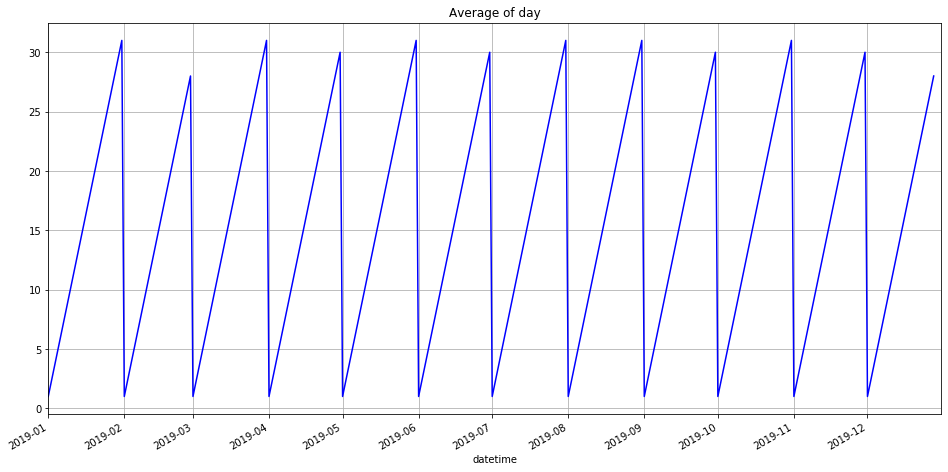

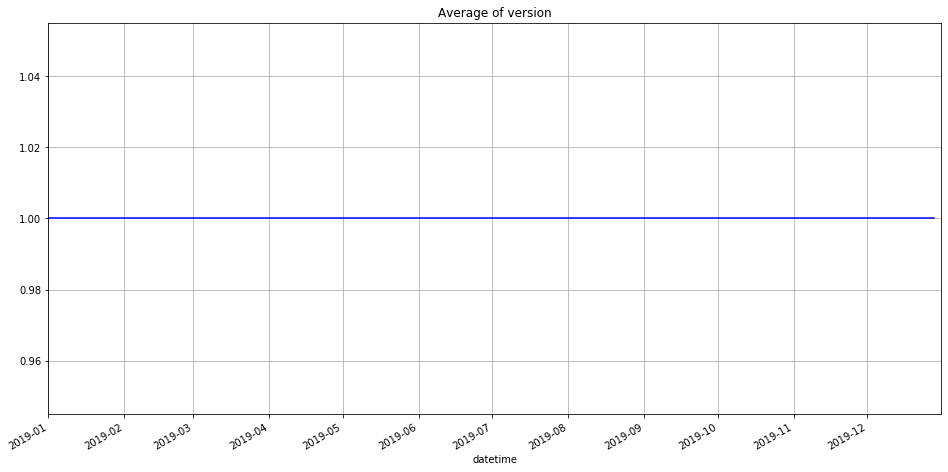

In [29]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, 1, 1), datetime(2019, 12, 31)])
    plt.grid()

In [30]:
#x = df.groupby(df.index)[['temperature', 'latitude']].corr()

In [31]:
c.close()

## Scale up with Azure ML and Dask

In [ ]:
run.cancel()

In [6]:
exp_name   = 'dask'
mount      = False
data_path  = '/mnt/noaa'
dset_input = ds.as_named_input('data').as_mount(data_path) if mount else ds.as_named_input('data').as_download(data_path)

script_params = {
    '--datastore': ws.get_default_datastore(),
    #'--script'   : 'run.py' # run code in run.py on cluster and teardown (batch processing)
}

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py', 
                environment_definition  = env, 
                script_params           = script_params,
                inputs                  = [dset_input],
                node_count              = 20,
                distributed_training    = MpiConfiguration()
               )

run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
#run = Experiment(ws, exp_name).submit(est)
run

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


Run(Experiment: dask,
Id: dask_1577725385_d0b95945,
Type: azureml.scriptrun,
Status: Running)

In [7]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Wait for cluster to setup

Wait for the cluster to spin up, the run to start, and the `start.py` script to complete. At this point, information needed for connecting the cluster will be logged back to the run.

The below cell waits for that information to be logged to the run, sets up port forwarding for the Dask dashboard, and prints the url. Make sure to check out the dashboard as you run through the rest of the notebook.

In [8]:
print('hi')

hi


In [32]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 7070

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    print(f'Setting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

waiting for scheduler node's ip
Setting up port forwarding...
Cluster is ready to use.


## Remote Dask Client setup

In [33]:
c = Client(f'tcp://{run.get_metrics()["scheduler"]}')
c.restart()

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')



<Client: 'tcp://10.1.0.8:8786' processes=20 threads=160, memory=1.18 TB>


In [41]:
files = dask.delayed(glob.glob)(f'{data_path}/year=*/month=*/*.parquet', recursive=True).compute()
files

['/mnt/noaa/year=2014/month=3/part-00001-tid-9219175779481662582-3729dfdb-ab32-4767-b9b6-11d2d644c3ce-80.c000.snappy.parquet',
 '/mnt/noaa/year=2014/month=7/part-00009-tid-9219175779481662582-3729dfdb-ab32-4767-b9b6-11d2d644c3ce-88.c000.snappy.parquet',
 '/mnt/noaa/year=2014/month=5/part-00003-tid-9219175779481662582-3729dfdb-ab32-4767-b9b6-11d2d644c3ce-82.c000.snappy.parquet',
 '/mnt/noaa/year=2014/month=8/part-00005-tid-9219175779481662582-3729dfdb-ab32-4767-b9b6-11d2d644c3ce-84.c000.snappy.parquet',
 '/mnt/noaa/year=2014/month=10/part-00002-tid-9219175779481662582-3729dfdb-ab32-4767-b9b6-11d2d644c3ce-81.c000.snappy.parquet',
 '/mnt/noaa/year=2014/month=4/part-00006-tid-9219175779481662582-3729dfdb-ab32-4767-b9b6-11d2d644c3ce-85.c000.snappy.parquet',
 '/mnt/noaa/year=2014/month=12/part-00004-tid-9219175779481662582-3729dfdb-ab32-4767-b9b6-11d2d644c3ce-83.c000.snappy.parquet',
 '/mnt/noaa/year=2014/month=6/part-00010-tid-9219175779481662582-3729dfdb-ab32-4767-b9b6-11d2d644c3ce-89.c000

In [42]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])
df.head()

usaf   wban            datetime  latitude  longitude  elevation  \
0  999999  53155 2014-03-01 00:00:00    35.755   -112.337     1826.0   
1  999999  53155 2014-03-01 00:05:00    35.755   -112.337     1826.0   
2  999999  53155 2014-03-01 00:10:00    35.755   -112.337     1826.0   
3  999999  53155 2014-03-01 00:15:00    35.755   -112.337     1826.0   
4  999999  53155 2014-03-01 00:20:00    35.755   -112.337     1826.0   

   windAngle  windSpeed  temperature  seaLvlPressure   ...     \
0        0.0        0.0         12.4             NaN   ...      
1        NaN        NaN         12.4             NaN   ...      
2        NaN        NaN         11.9             NaN   ...      
3        NaN        NaN         11.7             NaN   ...      
4        NaN        NaN         11.5             NaN   ...      

  pastWeatherIndicator  precipTime  precipDepth  snowDepth      stationName  \
0                  NaN         1.0          0.0        NaN  WILLIAMS 35 NNW   
1                  NaN         NaN          NaN        NaN  WILLIAMS 35 NNW   
2                  NaN         NaN          NaN        NaN  WILLIAMS 35 NNW   
3                  NaN         NaN          NaN        NaN  WILLIAMS 35 NNW   
4                  NaN         NaN          NaN        NaN  WILLIAMS 35 NNW   

   countryOrRegion           p_k  year day  version  
0               US  999999-53155  2014   1      1.0  
1               US  999999-53155  2014   1      1.0  
2               US  999999-53155  2014   1      1.0  
3               US  999999-53155  2014   1      1.0  
4               US  999999-53155  2014   1      1.0  

[5 rows x 22 columns]

In [43]:
%time len(df)

CPU times: user 340 ms, sys: 55.3 ms, total: 396 ms
Wall time: 15.2 s


1395199999

In [44]:
%time df.describe().compute()

CPU times: user 6.67 s, sys: 482 ms, total: 7.15 s
Wall time: 1min 37s


latitude     longitude     elevation     windAngle     windSpeed  \
count  1.395200e+09  1.395200e+09  1.395200e+09  1.120397e+09  1.163526e+09   
mean   3.743651e+01 -3.908364e+01  3.966978e+02  1.651781e+02  3.437612e+00   
std    2.160154e+01  7.861962e+01  6.093392e+02  1.145221e+02  2.864323e+00   
min   -9.000000e+01 -1.799990e+02 -3.880000e+02  0.000000e+00  0.000000e+00   
25%    3.405000e+01 -9.120000e+01  5.000000e+01  8.000000e+01  2.000000e+00   
50%    4.170600e+01 -5.057800e+01  2.090000e+02  1.900000e+02  3.600000e+00   
75%    4.922000e+01  2.136700e+01  5.490000e+02  2.800000e+02  5.700000e+00   
max    8.733300e+01  9.999990e+02  9.999000e+03  3.600000e+02  9.000000e+01   

        temperature  seaLvlPressure  presentWeatherIndicator  \
count  1.370008e+09    4.947240e+08             1.263201e+08   
mean   1.201580e+01    1.014648e+03             2.958524e+01   
std    1.247473e+01    9.361065e+00             2.924391e+01   
min   -9.130000e+01    8.600000e+02             0.000000e+00   
25%    8.500000e+00    1.011700e+03             1.000000e+01   
50%    1.610000e+01    1.017200e+03             4.900000e+01   
75%    2.780000e+01    1.026000e+03             7.100000e+01   
max    6.170000e+01    1.090000e+03             9.900000e+01   

       pastWeatherIndicator    precipTime   precipDepth     snowDepth  \
count          5.211754e+07  2.939545e+08  2.939545e+08  8.033333e+06   
mean           4.271468e+00  9.364511e+00  1.063696e+03  1.822055e+01   
std            2.998584e+00  2.020093e+01  3.068290e+03  3.392483e+01   
min            0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%            2.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00   
50%            6.000000e+00  3.000000e+00  0.000000e+00  1.500000e+01   
75%            8.000000e+00  2.400000e+01  9.999000e+03  6.300000e+01   
max            9.000000e+00  9.900000e+01  9.999000e+03  9.990000e+02   

               year           day       version  
count  1.395200e+09  1.395200e+09  1.395200e+09  
mean   2.013761e+03  1.570308e+01  1.000000e+00  
std    3.405101e+00  8.807051e+00  0.000000e+00  
min    2.008000e+03  1.000000e+00  1.000000e+00  
25%    2.012000e+03  8.000000e+00  1.000000e+00  
50%    2.016000e+03  1.600000e+01  1.000000e+00  
75%    2.019000e+03  2.400000e+01  1.000000e+00  
max    2.019000e+03  3.100000e+01  1.000000e+00

In [45]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 972 ms, sys: 72.9 ms, total: 1.05 s
Wall time: 54.3 s
Dataframe is: 676.33GB


In [46]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute()
means.head()

CPU times: user 2.51 s, sys: 148 ms, total: 2.66 s
Wall time: 4min 29s


latitude  longitude   elevation   windAngle  windSpeed  \
datetime                                                              
2014-03-01  37.495148 -42.324408  459.882649  161.490503   3.564584   
2014-03-02  37.498037 -43.069674  452.514444  167.128829   3.856767   
2014-03-03  37.469598 -42.230688  447.153022  169.973429   3.847857   
2014-03-04  37.529760 -41.349747  449.173936  150.405244   3.240598   
2014-03-05  37.548189 -41.616385  447.532317  144.974698   3.249770   

            temperature  seaLvlPressure  presentWeatherIndicator  \
datetime                                                           
2014-03-01     3.156394     1015.731252                26.813590   
2014-03-02     2.369242     1014.875352                27.712396   
2014-03-03     1.586917     1014.203672                29.180008   
2014-03-04     2.231378     1015.788630                28.964880   
2014-03-05     3.565344     1017.929068                27.059574   

            pastWeatherIndicator  precipTime  precipDepth  snowDepth    year  \
datetime                                                                       
2014-03-01              3.879101    5.962820   493.051272  29.870923  2014.0   
2014-03-02              3.793513    5.539633   435.597519  30.109880  2014.0   
2014-03-03              4.024144    5.751756   452.372539  29.071308  2014.0   
2014-03-04              4.051746    6.067853   484.122090  29.027386  2014.0   
2014-03-05              3.852251    5.950689   471.413154  29.852787  2014.0   

            day  version  
datetime                  
2014-03-01  1.0      1.0  
2014-03-02  2.0      1.0  
2014-03-03  3.0      1.0  
2014-03-04  4.0      1.0  
2014-03-05  5.0      1.0

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2019, 12, 31)])
    plt.grid()

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, 1, 1), datetime(2019, 12, 31)])
    plt.grid()

In [ ]:
#df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist()

## Prepare data

## Write data

In [ ]:
%time dask.delayed(df.to_parquet)(f'/{run.get_metrics()["datastore"]}/dask/output/noaa', partition_on=['year']).compute()

In [ ]:
df

## Create dataset

In [ ]:
from azureml.core import Dataset

dset = Dataset.File.from_files((ws.get_default_datastore(), '/dask/output/noaa/**/*.parquet'))

In [ ]:
dset = dset.register(ws, 'noaa-dask')
dset

## End the run

Cluster will return to 0 nodes

In [ ]:
run.cancel()

In [ ]:
df = df.drop(['datetime'], axis=1)

In [ ]:
df.index

In [ ]:
def write_data(path):
    df.to_parquet(path)

In [ ]:
a = dask.delayed(write_data)(ds+'/dask/outputs/isd').compute()

In [ ]:
counts = df.groupby([df.index.month, df.index.year]).day.count().compute()

In [ ]:
cs = [counts[month][2015] for month in range(1, 13)]
cs

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2015, 1, 1), datetime(2015, 12, 1)])
    plt.grid()
    
    run.log_image(col, plot=plt)

In [ ]:
df.memory_usage(index=True, deep=True).sum().compute()

In [ ]:
df.info()